# Tissue Non-Affine Registration

## Notebook Purpose

This notebook is designed to correct non-affine tissue deformations caused by shifts and stretching during tissue scanning. The pipeline focuses on non-affine registration using the Mattes Mutual Information (MMI) technique and includes hyperparameter optimization to improve the accuracy and robustness of the registration process.

## Imports

### Overview

- SimpleITK: Registration process
- SKlearn: PCA implementation
- Optuna: Optimalization of registration parameters.

In [ ]:
import pickle
from tissue_classes import Tissue, Slide
from pathlib import Path
import SimpleITK as sitk
import cv2
import numpy as np
import matplotlib.pyplot as plt
import optuna
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA

## Load Tissues

In [2]:
load_path = Path('../data/')
to_load = ['slide_affine_1.pkl', 'slide_affine_2.pkl']
slides = []

for file_path in load_path.glob('*.pkl'):
    if file_path.name in to_load:
        with open(file_path, 'rb') as f:
            print(f'Loading {file_path}...')
            obj: Slide = pickle.load(f)
            slides.append(obj)

Loading ..\data\slide_affine_1.pkl...
Loading ..\data\slide_affine_2.pkl...


In [3]:
for slide in slides:
    for tissue in slide:
        print(tissue.he.shape, tissue.mask.shape)

    print('New slide')

(2239, 2059, 2) (2239, 2059)
(2239, 2059, 2) (2239, 2059)
(2239, 2059, 2) (2239, 2059)
New slide
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
New slide


## Registration algorithm

The registration algorithm is based on a two-stage B-spline transformation optimized with Mattes Mutual Information (MMI). First, a coarse registration is performed on blurred images to capture large-scale deformations, followed by a fine registration step on higher-resolution data for precise alignment. The process uses an LBFGSB optimizer with multi-resolution smoothing and shrinking, optional masks for focusing on tissue regions, and composite transforms to combine initial, coarse, and fine adjustments. 

This split allows the algorithm to first align global structures on a coarse grid, reducing computational cost, and then refine local details on a finer grid, resulting in faster and more accurate registration overall.

In [4]:
def mmi_register(
    img1: np.ndarray, img2: np.ndarray,
    mask1: np.ndarray = None, mask2: np.ndarray = None,
    initial_transform: sitk.Transform = None,
    register = False,

    num_bins: int = 100,
    metric_sampling_strategy: str = "RANDOM",
    metric_sampling_percentage: float = 0.4,
    metric_use_gradient: bool = True,

    coarse_iterations: int = 150,
    coarse_tol: float = 1e-5,
    coarse_max_corrections: int = 5,
    coarse_max_func_evals: int = 300,
    coarse_cost_factor: float = 1e8,

    fine_iterations: int = 250,
    fine_tol: float = 1e-6,
    fine_max_corrections: int = 7,
    fine_max_func_evals: int = 500,
    fine_cost_factor: float = 1e9,
    fine_metric_sampling_percentage: float = 0.6,

    shrink_factors: list = [4, 2, 1],
    smoothing_sigmas: list = [2.5, 1.2, 0],

    coarse_grid_spacing: list = [10, 10],
    fine_grid_spacing: list = [32, 32],
    spline_order: int = 3,

    blur_sigma: float = 3.0
) -> tuple[sitk.Image, sitk.Transform]:
    img1_sitk = sitk.GetImageFromArray(img1.astype(np.float32))
    img2_sitk = sitk.GetImageFromArray(img2.astype(np.float32))
    img1_sitk.SetSpacing((1.0,) * img1_sitk.GetDimension())
    img2_sitk.SetSpacing((1.0,) * img2_sitk.GetDimension())
    img1_sitk.SetOrigin((0.0,) * img1_sitk.GetDimension())
    img2_sitk.SetOrigin((0.0,) * img2_sitk.GetDimension())

    mask1_sitk, mask2_sitk = None, None
    if mask1 is not None and mask2 is not None:
        mask1 = mask1.astype(np.uint8)
        mask2 = mask2.astype(np.uint8)
        kernel = np.ones((7, 7), np.uint8)
        mask1 = cv2.erode(mask1, kernel, iterations=1)
        mask2 = cv2.erode(mask2, kernel, iterations=1)
        mask1_sitk = sitk.GetImageFromArray(mask1.astype(np.uint8))
        mask2_sitk = sitk.GetImageFromArray(mask2.astype(np.uint8))
        mask1_sitk.CopyInformation(img1_sitk)
        mask2_sitk.CopyInformation(img2_sitk)

    def configure_registration(fixed, moving, fixed_mask, moving_mask, transform, 
                               sampling_percentage, iterations, tol, max_corr, max_eval, cost_factor):
        reg = sitk.ImageRegistrationMethod()

        reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=num_bins)
        reg.SetMetricSamplingStrategy(getattr(reg, metric_sampling_strategy))
        reg.SetMetricSamplingPercentage(sampling_percentage)
        reg.SetMetricUseFixedImageGradientFilter(metric_use_gradient)
        reg.SetMetricUseMovingImageGradientFilter(metric_use_gradient)

        if fixed_mask is not None:
            reg.SetMetricFixedMask(fixed_mask)
        if moving_mask is not None:
            reg.SetMetricMovingMask(moving_mask)

        reg.SetOptimizerAsLBFGSB(
            gradientConvergenceTolerance=tol,
            numberOfIterations=iterations,
            maximumNumberOfCorrections=max_corr,
            maximumNumberOfFunctionEvaluations=max_eval,
            costFunctionConvergenceFactor=cost_factor
        )
        reg.SetOptimizerScalesFromPhysicalShift()
        reg.SetInterpolator(sitk.sitkBSpline)

        reg.SetShrinkFactorsPerLevel(shrink_factors)
        reg.SetSmoothingSigmasPerLevel(smoothing_sigmas)
        reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        reg.SetInitialTransform(transform, inPlace=False)
        return reg

    if initial_transform:
        img2_sitk = sitk.Resample(
            img2_sitk,
            img1_sitk,
            initial_transform,
            sitk.sitkBSpline
        )

    coarse_transform = sitk.BSplineTransformInitializer(
        img1_sitk,
        coarse_grid_spacing,
        order=spline_order
    )

    img1_blurred = sitk.DiscreteGaussian(img1_sitk, blur_sigma)
    img2_blurred = sitk.DiscreteGaussian(img2_sitk, blur_sigma)

    reg_coarse = configure_registration(
        img1_blurred,
        img2_blurred,
        mask1_sitk,
        mask2_sitk,
        coarse_transform,
        metric_sampling_percentage,
        coarse_iterations,
        coarse_tol,
        coarse_max_corrections,
        coarse_max_func_evals,
        coarse_cost_factor
    )
    tform_coarse = reg_coarse.Execute(img1_blurred, img2_blurred)

    img2_warped = sitk.Resample(
        img2_sitk,
        img1_sitk,
        tform_coarse,
        sitk.sitkBSpline
    )

    fine_transform = sitk.BSplineTransformInitializer(
        img1_sitk,
        fine_grid_spacing,
        order=spline_order
    )

    reg_fine = configure_registration(
        img1_sitk,
        img2_warped,
        mask1_sitk,
        mask2_sitk,
        fine_transform,
        fine_metric_sampling_percentage,
        fine_iterations,
        fine_tol,
        fine_max_corrections,
        fine_max_func_evals,
        fine_cost_factor
    )

    tform_fine = reg_fine.Execute(img1_sitk, img2_warped)

    final_transform = sitk.CompositeTransform(img1_sitk.GetDimension())
    if initial_transform:
        final_transform.AddTransform(initial_transform)
    final_transform.AddTransform(tform_coarse)
    final_transform.AddTransform(tform_fine)

    if register:
        reg_img = sitk.Resample(
            img2_sitk,
            img1_sitk,
            final_transform,
            sitk.sitkBSpline
        )

        return sitk.GetArrayFromImage(reg_img), final_transform
    return final_transform

def merge_pca(tissue):
    hem, eos = tissue.hem, tissue.eos

    flat = np.stack([hem.ravel(), eos.ravel()], axis=1)
    pca = PCA(n_components=1)
    merged = pca.fit_transform(flat).reshape(hem.shape)
    return merged

`tissue_register` is a simple wrapper combinining conversion images from NumPy arrays to SimpleITK image opbjects, registration and resampling process. 

In [5]:
def tissue_register(tissue1, tissue2, sitk_trans):
    hem1, eos1 = tissue1.hem, tissue1.eos
    hem2, eos2 = tissue2.hem, tissue2.eos
    mask1, mask2 = tissue1.mask.astype(np.uint8), tissue2.mask.astype(np.uint8)
    
    hem1, eos1 = sitk.GetImageFromArray(hem1), sitk.GetImageFromArray(eos1)
    hem2, eos2 = sitk.GetImageFromArray(hem2), sitk.GetImageFromArray(eos2)
    mask1, mask2 = sitk.GetImageFromArray(mask1), sitk.GetImageFromArray(mask1)


    for img in [hem1, eos1, hem2, eos2]:
        img.SetSpacing((1.0, 1.0))
        img.SetOrigin((0.0, 0.0))

    reg_hem = sitk.Resample(
        hem2,
        hem1,
        sitk_trans,
        sitk.sitkBSpline
    )
    reg_eos = sitk.Resample(
        eos2,
        eos1,
        sitk_trans,
        sitk.sitkBSpline
    )
    reg_mask = sitk.Resample(
        mask2,
        mask2,
        sitk_trans,
        sitk.sitkBSpline
    )

    dtype = tissue2.he.dtype
    reg_tissue = Tissue(
        he = np.dstack([sitk.GetArrayFromImage(reg_hem).astype(dtype), sitk.GetArrayFromImage(reg_eos).astype(dtype)]),
        rgb = tissue2.rgb,
        mask=sitk.GetArrayFromImage(reg_mask).astype(bool)
    )

    return reg_tissue

## Metric

This section of the notebook is documented in the **AffineRegistration** notebook under the paragraph with the same title.


In [6]:
metric_count = 3

def metric(
           tissue1: np.ndarray,
           tissue2: np.ndarray
    ):

    def NGF(i1, i2, epsilon=1e-6):
        def grad(i):
            gx = cv2.Sobel(i, cv2.CV_64F, 1, 0, ksize=3)
            gy = cv2.Sobel(i, cv2.CV_64F, 0, 1, ksize=3)
            g = np.stack((gx, gy), axis=-1)
            norm = np.sqrt(np.sum(g**2, axis=-1, keepdims=True) + epsilon**2)
            return g / norm
        n1 = grad(i1)
        n2 = grad(i2)
        dp = np.sum(n1 * n2, axis=-1)
        return np.mean(1 - dp**2)
    
    def MSE(i1, i2):
        err = np.square(i1.astype("float") - i2.astype("float"))
        
        return np.mean(err)

    mean_metric = lambda metric, t1, t2: np.mean([
        metric(t1[..., c], t2[..., c])
        for c in range(t1.shape[-1])
    ])

    mse_v = mean_metric(MSE, tissue1, tissue2)
    ngf_v = mean_metric(NGF, tissue1, tissue2)
    ssim_v = mean_metric(ssim, tissue1, tissue2)

    return {'MSE' : mse_v, 'NGF' : ngf_v, 'SSIM' : ssim_v}

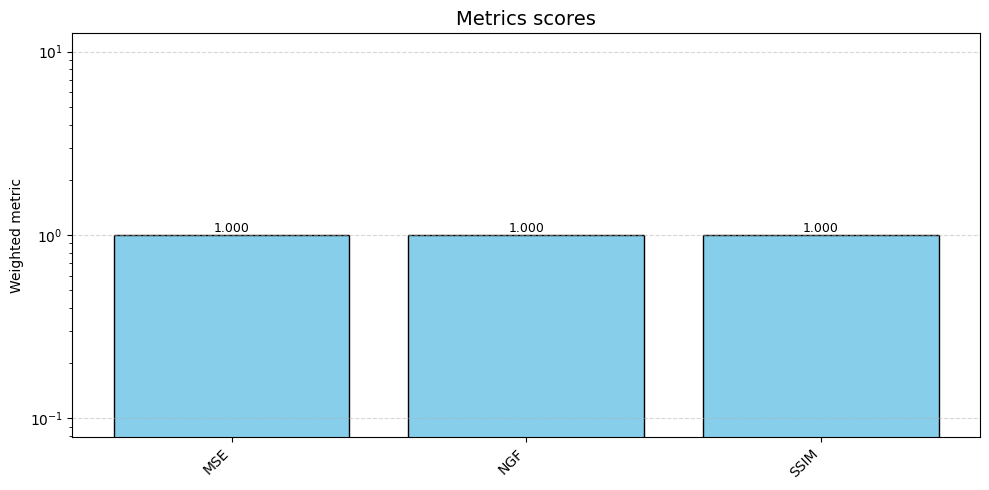

In [7]:
def plot_score(scores, ax=None):
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_ax = True

    sorted_met = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
    labels = list(sorted_met.keys())
    values = list(sorted_met.values())

    ax.bar(labels, values, color='skyblue', edgecolor='black')
    ax.set_title('Metrics scores', fontsize=14)
    ax.set_ylabel('Weighted metric')
    ax.set_yscale('log')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    for i, val in enumerate(values):
        ax.text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    if created_ax:
        plt.tight_layout()
        plt.show()
    else:
        return ax
    
plot_score({'MSE':1, 'NGF':1, 'SSIM':1})

## Parameter optimalization

The optimization process begins with 10 random trials to broadly explore the search space and reduce the risk of premature convergence. This is followed by 20 additional trials using the NSGA-II algorithm, a powerful multi-objective evolutionary method that balances exploration and exploitation, enabling an efficient search for diverse high-quality solutions across the parameter space.

In [ ]:
train_slide_index = 1
valid_slide_index = 0

random_trials = 10
nsgaii_trials = 20
trials_seed = 5

`choose_register_hyperparams` assembles fixed and dynamic parameters choosed by optuna strategy.

In [ ]:
def choose_register_hyperparams(trial):
    shrink_factors = [8]
    smoothing_sigmas = [2.5]
    coarse_grid_spacing = [10, 10]
    fine_grid_spacing = [32, 32]
    spline_order = 3
    metric_sampling_strategy = "RANDOM"
    initial_transform = None

    trial.set_user_attr("shrink_factors", shrink_factors)
    trial.set_user_attr("smoothing_sigmas", smoothing_sigmas)
    trial.set_user_attr("coarse_grid_spacing", coarse_grid_spacing)
    trial.set_user_attr("fine_grid_spacing", fine_grid_spacing)
    trial.set_user_attr("spline_order", spline_order)
    trial.set_user_attr("metric_sampling_strategy", metric_sampling_strategy)
    trial.set_user_attr("initial_transform", initial_transform)

    return lambda ch1, ch2, mask1, mask2: mmi_register(
        img1=ch1,
        img2=ch2,
        mask1=None,
        mask2=None,
        initial_transform=initial_transform,
        register=False,

        num_bins=trial.suggest_int("num_bins", 30, 50),
        metric_sampling_strategy=metric_sampling_strategy,
        metric_sampling_percentage=trial.suggest_float("metric_sampling_percentage", 0.55, 0.75),
        metric_use_gradient=trial.suggest_categorical("metric_use_gradient", [True, False]),

        coarse_iterations=trial.suggest_int("coarse_iterations", 30, 60),
        coarse_tol=trial.suggest_float("coarse_tol", 1e-5, 5e-5, log=True),
        coarse_max_corrections=trial.suggest_int("coarse_max_corrections", 3, 5),
        coarse_max_func_evals=trial.suggest_int("coarse_max_func_evals", 60, 120),
        coarse_cost_factor=trial.suggest_float("coarse_cost_factor", 1e6, 1e7, log=True),

        fine_iterations=trial.suggest_int("fine_iterations", 70, 120),
        fine_tol=trial.suggest_float("fine_tol", 1e-6, 5e-6, log=True),
        fine_max_corrections=trial.suggest_int("fine_max_corrections", 3, 5),
        fine_max_func_evals=trial.suggest_int("fine_max_func_evals", 180, 250),
        fine_cost_factor=trial.suggest_float("fine_cost_factor", 1e8, 1e9, log=True),
        fine_metric_sampling_percentage=trial.suggest_float("fine_metric_sampling_percentage", 0.5, 0.7),

        shrink_factors=shrink_factors,
        smoothing_sigmas=smoothing_sigmas,
        coarse_grid_spacing=coarse_grid_spacing,
        fine_grid_spacing=fine_grid_spacing,
        spline_order=spline_order,
        blur_sigma=trial.suggest_float("blur_sigma", 2.5, 3.2)
    )


The functions `optimize_nonaffine` and `validate_nonaffine` perform non-rigid registration tuning and evaluation. Both use PCA-based channel merging to generate inputs, with the first averaging metric scores (MSE, NGF, SSIM) over training pairs, and the second validating on unseen slides with optional visualizations of channel differences and metrics


In [ ]:
def optimize_nonaffine(trial):
    register_function = choose_register_hyperparams(trial) 

    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slides[train_slide_index])):
        tissue1 = slides[train_slide_index][j-1]
        tissue2 = slides[train_slide_index][j]
        
        combined1, combined2 = merge_pca(tissue1), merge_pca(tissue2)

        try:
            transform = register_function(
                combined1, combined2,
                tissue1.mask, tissue2.mask
            )

            registered = tissue_register(tissue1, tissue2, transform)

            score = metric(tissue1.he, registered.he)

            avg_score = [avg_s + s for avg_s, s in zip(avg_score, score.values())]
            count += 1
        except Exception as e:
            print(f'Warning: Parameters failed !')
            print(f'Error message: {e}')
            return [np.inf, np.inf, -np.inf]

    avg_score = [score / count for score in avg_score]
    return avg_score

def validate_nonaffine(params, plot=True):
    if plot:
        n = len(slides[valid_slide_index])-1
        fig, axes = plt.subplots(n, 3, figsize=(15,5*n), gridspec_kw={'width_ratios': [1, 1, 2]})
        
        if n == 1:
            axes = axes.reshape(1, -1)
    
    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slides[valid_slide_index])):
        tissue1 = slides[valid_slide_index][j-1]
        tissue2 = slides[valid_slide_index][j]
        
        combined1, combined2 = merge_pca(tissue1), merge_pca(tissue2)

        try:        
            transform = mmi_register(
                combined1, combined2,
                tissue1.mask, tissue2.mask,
                register=False,
                **params
            )            
            registered = tissue_register(tissue1, tissue2, transform)
            score = metric(tissue1.he, registered.he)

            avg_score = [avg_s + s for avg_s, s in zip(avg_score, score.values())]
            count += 1
        except Exception as e:
            print(f'Validation failed! Error: {e}')
            return [np.inf, np.inf, -np.inf]

        if plot:
                axes[j-1,0].imshow(cv2.absdiff(tissue1.hem, registered.hem), cmap='magma')
                axes[j-1,0].axis('off')
                axes[j-1,1].imshow(cv2.absdiff(tissue1.eos, registered.eos), cmap='magma')
                axes[j-1,1].axis('off')
                plot_score(score, axes[j-1,2])
    
    if plot:
        fig.suptitle('Validation of hyper parameter optimalization', fontsize=20)
        plt.tight_layout()
        plt.show()


    avg_score = [score / count for score in avg_score]
    return avg_score

### Random search

The random strategy optimization yielded stable performance across trials, with NGF values consistently above 0.80 and SSIM around 0.77, indicating good structural alignment between tissue layers. The best result was obtained in Trial 8, achieving the lowest MSE (≈293), while maintaining strong NGF (0.804) and the highest SSIM (0.777). This suggests that the selected parameter set provides a favorable balance between geometric accuracy and structural similarity. The results confirm that the search strategy effectively converged towards a robust configuration.

In [11]:
study = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(
        seed=trials_seed
    ),
    directions=["minimize", "minimize", "maximize"]
)

study.optimize(optimize_nonaffine, n_trials=random_trials)

def score_trial(trial):
    mse, ngf, ssim = trial.values
    return 0.7 * mse + 0.2 * ngf - 0.2 *  ssim

best_trial = min(study.best_trials, key=score_trial)
best_params = {**best_trial.params, **best_trial.user_attrs}

print("Best scores:", best_trial.values)
print("Best params:", best_params)

[I 2025-07-19 21:34:00,320] A new study created in memory with name: no-name-00eed3c7-236c-4744-bd81-83a884421e88
[I 2025-07-19 21:36:52,317] Trial 0 finished with values: [298.22920247892984, 0.8042078447531779, 0.7761586651679186] and parameters: {'num_bins': 34, 'metric_sampling_percentage': 0.6612196918532129, 'metric_use_gradient': False, 'coarse_iterations': 35, 'coarse_tol': 4.090193581808673e-05, 'coarse_max_corrections': 5, 'coarse_max_func_evals': 102, 'coarse_cost_factor': 3922843.6865411554, 'fine_iterations': 59, 'fine_tol': 1.2043182531873043e-06, 'fine_max_corrections': 5, 'fine_max_func_evals': 166, 'fine_cost_factor': 143982552.27198935, 'fine_metric_sampling_percentage': 0.6639811093603836, 'blur_sigma': 1.5481729239844493}.
[I 2025-07-19 21:38:57,765] Trial 1 finished with values: [307.51344402256916, 0.8045089100598264, 0.7719282860962204] and parameters: {'num_bins': 38, 'metric_sampling_percentage': 0.4888239798200944, 'metric_use_gradient': True, 'coarse_iteratio

Best scores: [293.4212645299508, 0.8035816323368961, 0.7770182985324707]
Best params: {'num_bins': 37, 'metric_sampling_percentage': 0.6430942696337055, 'metric_use_gradient': False, 'coarse_iterations': 45, 'coarse_tol': 1.8375466549183455e-05, 'coarse_max_corrections': 3, 'coarse_max_func_evals': 74, 'coarse_cost_factor': 1479588.4194886195, 'fine_iterations': 91, 'fine_tol': 1.4799603342661675e-06, 'fine_max_corrections': 3, 'fine_max_func_evals': 223, 'fine_cost_factor': 646078857.3620287, 'fine_metric_sampling_percentage': 0.5768121634701228, 'blur_sigma': 2.829468680234924, 'shrink_factors': [8], 'smoothing_sigmas': [2.5], 'coarse_grid_spacing': [10, 10], 'fine_grid_spacing': [32, 32], 'spline_order': 3, 'metric_sampling_strategy': 'RANDOM', 'initial_transform': None}


AAA
AAA


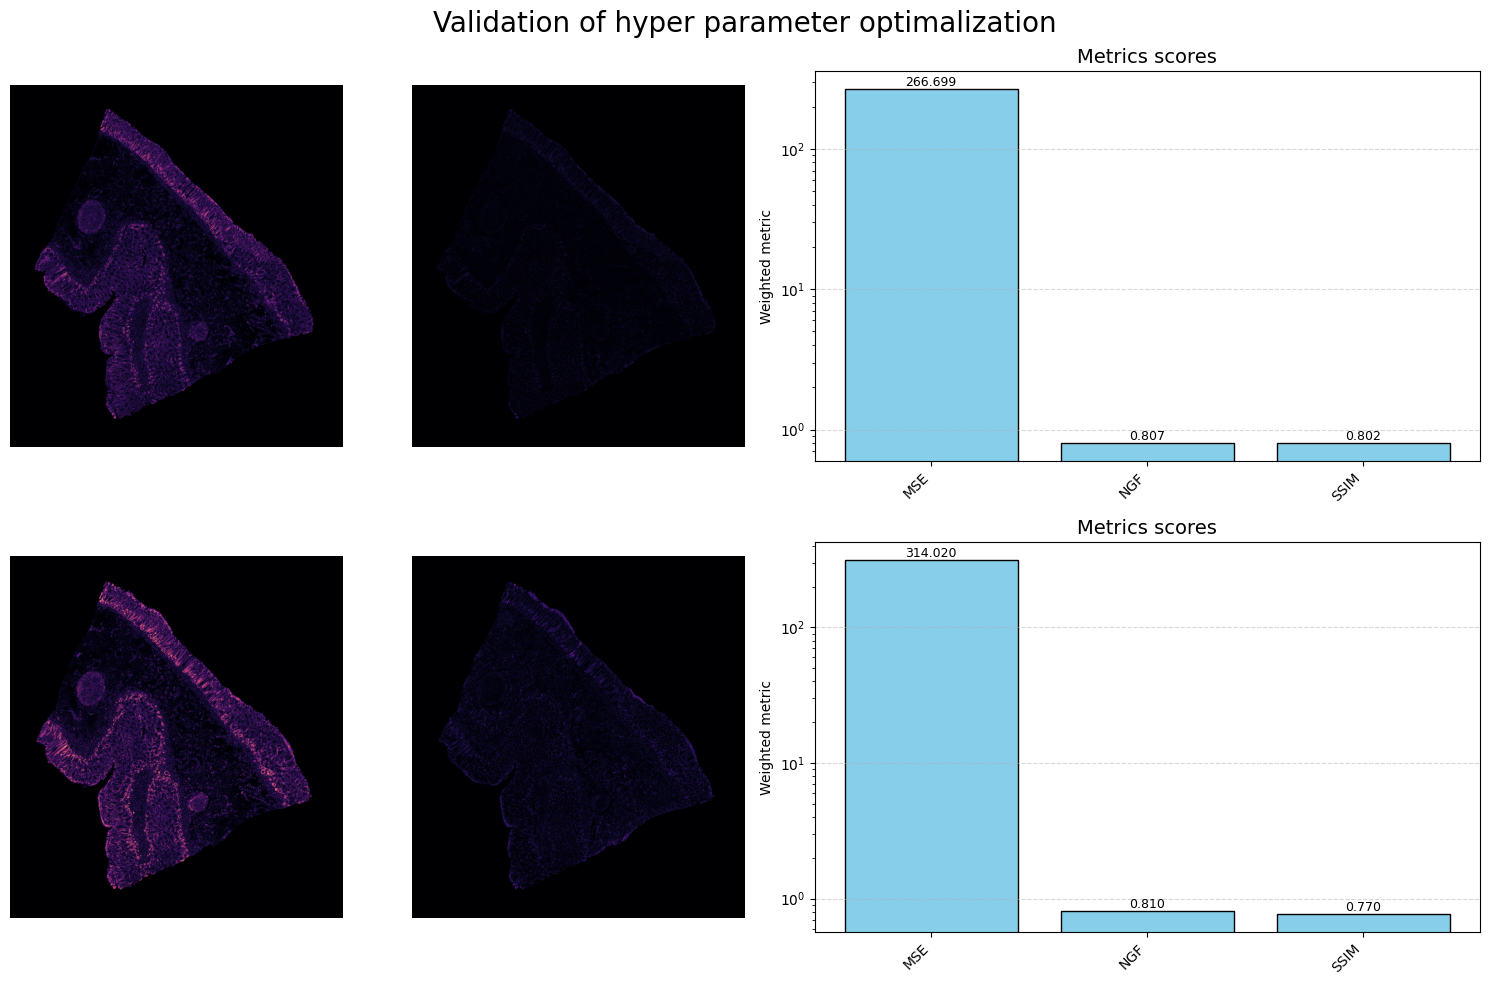

[np.float64(290.35960616697986),
 np.float64(0.80840060211317),
 np.float64(0.7859389573125115)]

In [12]:
validate_nonaffine(best_params)

### Search using NSGA-II algorithm

In [ ]:
study.sampler = optuna.samplers.NSGAIISampler(seed=trials_seed)
study.optimize(optimize_nonaffine, n_trials=nsgaii_trials)

best_trial = min(study.best_trials, key=score_trial)

print("Best scores:", best_trial.values)
print("Best params:", best_trial.user_attrs['params'])

In [13]:
import json
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"optun_affine_{timestamp}.json"

save = '../data/' + filename

with open(save, "w") as f:
    best_result = {
        "score": best_trial.values,
        "params": best_params
    }

    json.dump(best_result, f, indent=4)